# Стартап по породаже продуктов питания

# Оглавление <a name="шаг-0"></a>
   [Исследование пользователей мобильного приложения по продаже продуктов питания. Введение](#0)
   
1. [Шаг 1. Открытие файла с данными и изучение общей информации](#1)

2. [Шаг 2. Подготовка данных](#2)
    
3. [Шаг 3. Изучение и проверка данных](#3)
    
4. [Шаг 4. Изучение воронки событий](#4)
    
5. [Шаг 5. Изучение результатов эксперимента](#5)   


# Введение
**Цель исследования:** Исследование поведения  пользователей   мобильного приложения.

**Описание требований:** 
Изучить воронку продаж,  узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.
Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, можно быть уверенным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента следует работать с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Данные для анализа:**
  
записи в логе:

    - EventName — название события;
    - DeviceIDHash — уникальный идентификатор пользователя;
    - EventTimestamp — время события;
    - ExpId -номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


# Шаг 1. Открытие файла с данными и изучение общей информации  <a name="1"></a>

In [67]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from scipy import stats as st
from scipy.stats import norm
import math as mth
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px

In [68]:
try:
    logs= pd.read_csv('/datasets/logs_exp.csv', sep='\t') 
except:
    logs= pd.read_csv(r'C:\Users\Larissa Olifirova\Desktop\Яндекс практикум\9 сборный проект -2 Событийная аналитика\logs_exp.csv', sep='\t') 

In [69]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [70]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [71]:
#столбец EventTimestamp в формате unix-time переведём в формат datetime64:
logs['EventTimestamp'] = logs['EventTimestamp'].astype('datetime64[s]')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


# Вывод:
Данные содержат 244126  строк без пропусков. Столбец с датами был переформатирован к datetime64.

# Шаг 2. Подготовка данных  <a name="2"></a>

##### задачи:
- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат

In [72]:
logs.columns=['event_name', 'device_id_hash', 'event_datetime', 'exp_id'] #переименуем столбцы
logs.head()

,event_name,device_id_hash,event_datetime,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [73]:
logs.duplicated().sum()

413

In [74]:
logs[logs.duplicated(keep=False)].head()

,event_name,device_id_hash,event_datetime,exp_id
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248


Данные содержат 413 дубликатов и причина их появления не известна, визуальный анализ не показал никаких явных зависимостей. Можно предположить, что данные задублировались в результате технического сбоя, поскольку наблюдается совпадение по времени в долях секунд. Удалим эти данные:

In [75]:
logs = logs.drop_duplicates().reset_index(drop=True)
logs.shape

(243713, 4)

In [76]:
logs.tail()

,event_name,device_id_hash,event_datetime,exp_id
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246
243712,OffersScreenAppear,5746969938801999050,2019-08-07 21:15:17,246


Также изменим номера экспериментальных групп на буквенные обозначения: 246 - А1, 247 -А2, 248 - В, где А1 и А2 - контрольные группы, а В - экспериментальная:

In [77]:
#logs['exp_id']=logs['exp_id'].replace(to_replace =[246,247,248], value =[A1, A2, B])
logs['exp_id']=logs['exp_id'].map({246:'A1',247:'A2', 248: 'B'})

In [78]:
#добавим дату  в отдельный столбец
logs['event_date']= logs['event_datetime'].dt.date
logs['event_date'] = logs['event_date'].astype('datetime64[s]')
logs.head()

,event_name,device_id_hash,event_datetime,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [79]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   device_id_hash  243713 non-null  int64         
 2   event_datetime  243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  object        
 4   event_date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


In [80]:
logs_2= logs.copy()

# Вывод:
Данные содержат 413 дубликатов, которые были удалены. В таблицу добавлен столбец с датой. Номера экспериментальных и контрольной групп заменены на буквенные обозначения.

#### [Вернуться к оглавлению](#шаг-0)

# Шаг 3. Изучение и проверка данных  <a name="3"></a>

##### задачи:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

##### Сколько всего событий в логе

In [81]:
logs['event_name'].nunique() #всего уникальных событий

5

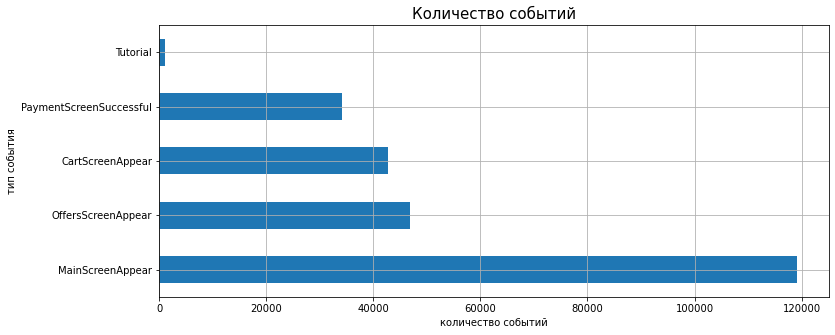

In [82]:
event = logs['event_name'].value_counts()
event.plot(figsize=(12,5), kind='barh', cmap = 'tab10')
plt.title('Количество событий', fontsize = 15)
plt.ylabel('тип события')
plt.xlabel('количество событий')
plt.grid();

In [83]:
event=event.reset_index()
event

,index,event_name
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Всего в логе 5 событий, которые фактически представляют воронку.

##### Сколько всего пользователей в логе

In [84]:
logs['device_id_hash'].nunique() #всего уникальных пользователей

7551

##### Сколько в среднем событий приходится на пользователя

Изучим device_id_hash и определим количество событий для пользователей:

In [85]:
users = logs['device_id_hash'].value_counts().reset_index()
users.head()

,index,device_id_hash
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221


In [86]:
logs.query('device_id_hash == "6304868067479728361"').head(10) #исследовние данных для пользователя с наибольшим количеством событий

,event_name,device_id_hash,event_datetime,exp_id,event_date
32882,MainScreenAppear,6304868067479728361,2019-08-01 18:01:25,B,2019-08-01
32893,CartScreenAppear,6304868067479728361,2019-08-01 18:01:43,B,2019-08-01
32894,PaymentScreenSuccessful,6304868067479728361,2019-08-01 18:01:43,B,2019-08-01
32896,MainScreenAppear,6304868067479728361,2019-08-01 18:01:44,B,2019-08-01
32897,OffersScreenAppear,6304868067479728361,2019-08-01 18:01:52,B,2019-08-01
32905,OffersScreenAppear,6304868067479728361,2019-08-01 18:02:06,B,2019-08-01
32961,OffersScreenAppear,6304868067479728361,2019-08-01 18:04:15,B,2019-08-01
32964,PaymentScreenSuccessful,6304868067479728361,2019-08-01 18:04:19,B,2019-08-01
32965,CartScreenAppear,6304868067479728361,2019-08-01 18:04:19,B,2019-08-01
32981,PaymentScreenSuccessful,6304868067479728361,2019-08-01 18:04:52,B,2019-08-01


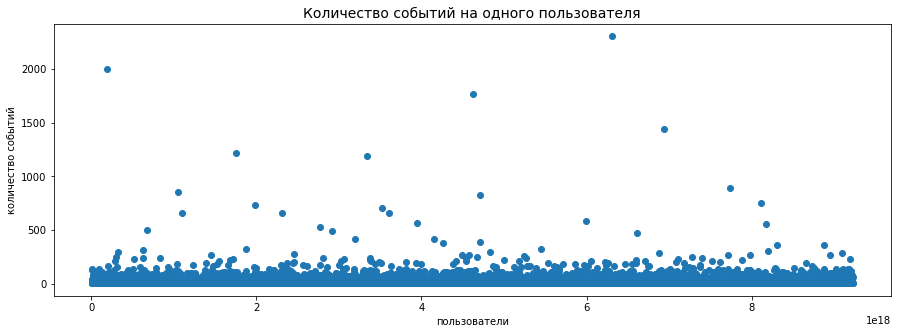

In [87]:
plt.figure(figsize=(15,5))
plt.scatter(users['index'], users['device_id_hash'])
plt.title('Количество событий на одного пользователя', fontsize = 14)
plt.xlabel('пользователи')
plt.ylabel('количество событий');

In [88]:
users.describe()

,index,device_id_hash
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


In [89]:
users['device_id_hash'].agg(['mean', 'median'])

mean      32.275593
median    20.000000
Name: device_id_hash, dtype: float64

Диаграмма показывает, что  количество событий в среднем на одного пользователя равно 32, медианное количество событий  - 20. Рассчитаем  процентили распределения количества событий:

In [90]:
np.percentile(users['device_id_hash'], [50, 60, 70, 80, 90, 95, 98, 99])

array([ 20. ,  26. ,  33. ,  43. ,  64. ,  89. , 136. , 200.5])

Очевидно, что количество событий более 136 (2%) на одного пользователя является аномалией. Удалим эти значения:

In [91]:
event.sum()

index         MainScreenAppearOffersScreenAppearCartScreenAp...
event_name                                               243713
dtype: object

In [92]:
users= users.query('device_id_hash < 136')
users_norm = users['index']
users_norm.shape

(7398,)

In [93]:
logs = logs[logs.device_id_hash.isin(users_norm)]
logs.shape #число событий  после устранения аномалий

(196579, 5)

In [94]:
users['device_id_hash'].agg(['mean', 'median']) #среднее и медиана после устранения выбросов

mean      26.571911
median    19.000000
Name: device_id_hash, dtype: float64

In [95]:
users.describe()

,index,device_id_hash
count,7.398000e+03,7398.000000
mean,4.681053e+18,26.571911
std,2.657299e+18,24.041381
min,6.888747e+15,1.000000
25%,2.397148e+18,9.000000
50%,4.689583e+18,19.000000
75%,7.015139e+18,36.000000
max,9.222603e+18,135.000000


In [96]:
users_2 = logs_2['device_id_hash'].value_counts().reset_index()
users_2 = users_2[~((users_2-users_2.mean()).abs() > 3*users_2.std())]
users_2.describe()

,index,device_id_hash
count,7.551000e+03,7494.000000
mean,4.677319e+18,28.474780
std,2.655343e+18,29.291174
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,19.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,226.000000


##### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [97]:
logs['event_date'].agg([min, 'max'])

min   2019-07-25
max   2019-08-07
Name: event_date, dtype: datetime64[ns]

In [98]:
dat = logs.groupby(['event_date'])['device_id_hash'].count().reset_index()
dat

,event_date,device_id_hash
0,2019-07-25,9
1,2019-07-26,29
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,409
6,2019-07-31,1812
7,2019-08-01,29331
8,2019-08-02,27712
9,2019-08-03,26324


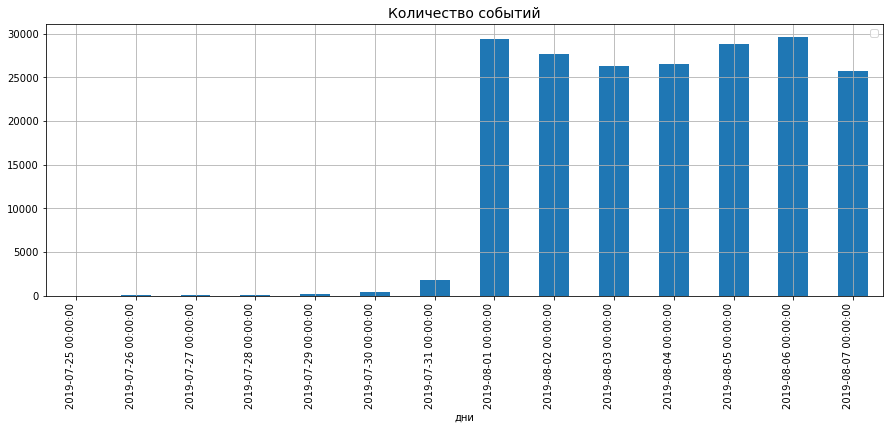

In [99]:
dat.plot(kind='bar', x='event_date', figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.title('Количество событий', fontsize = 14)
plt.xlabel('дни')
plt.legend('')
plt.grid();

Здесь видим, что в течение 14 дней общее число событий распределено неравномерно и пользовательская активность фиксируется только со второй недели. Оставим данные только с 1 августа 2019 года:

In [100]:
# dat= dat.query('event_date >= "2019-08-01"')
# dat_norm = dat['event_date']
# dat_norm.shape

In [101]:
logs = logs.query('event_date >= "2019-08-01"')
logs.shape #число событий  после устранения пустых дат

(193976, 5)

##### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [102]:
event['event_name'].sum()-logs['event_name'].count()

49737

In [103]:
1-(logs['event_name'].count()/event['event_name'].sum())

0.20408020909840674

In [104]:
users['index'].count()-logs['device_id_hash'].nunique()

17

In [105]:
1-(logs['device_id_hash'].nunique()/users['index'].count())


0.002297918356312545

В результате отброса старых данных были потеряны 49737 событий (20.4%) и 17 пользователей (0.23%).

#####  Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [106]:
logs['exp_id'].unique()

array(['A1', 'A2', 'B'], dtype=object)

В очищенные данные вошли данные всех экспериментов.

# Вывод:
Всего в логе 5 уникальных событий (которые фактически представляют воронку).
Количество уникальных пользователей - 7551.
Диаграмма показывает, что основное количество событий в среднем равно 32, медианное количество событий на одного пользователя - 20.  Количество событий более 136 (2%) на одного пользователя является аномалией.После устранения выбросов среднее количество событий составило- 26,6.
Исследуемый период времени  - 14 дней с 25.07.2019 по 07.08.2019. Данные за первую неделю были удалены, т.к. основная доля событий приходится на 2 неделю с 1.08.2019 по 07.08.2019. В результате отброса старых данных были потеряны 49737 событий и 17 пользователей.


#### [Вернуться к оглавлению](#шаг-0)

# Шаг 4. Изучение воронки событий <a name="4"></a>

##### задачи:
- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

##### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [107]:
logs['event_name'].value_counts().reset_index()

,index,event_name
0,MainScreenAppear,109179
1,OffersScreenAppear,37544
2,CartScreenAppear,26409
3,PaymentScreenSuccessful,19880
4,Tutorial,964


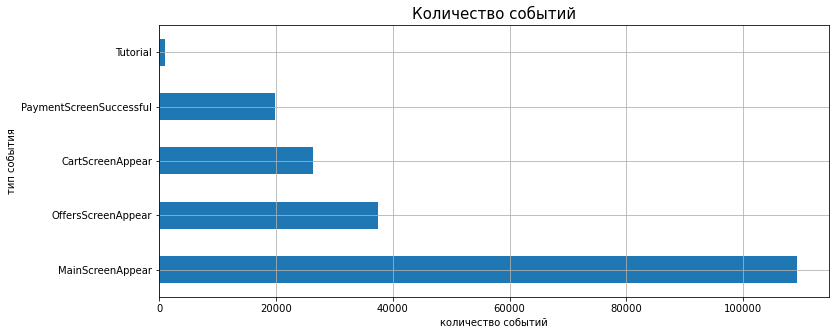

In [108]:
logs['event_name'].value_counts().plot(figsize=(12,5), kind='barh', cmap = 'tab10')
plt.title('Количество событий', fontsize = 15)
plt.ylabel('тип события')
plt.xlabel('количество событий')
plt.grid();

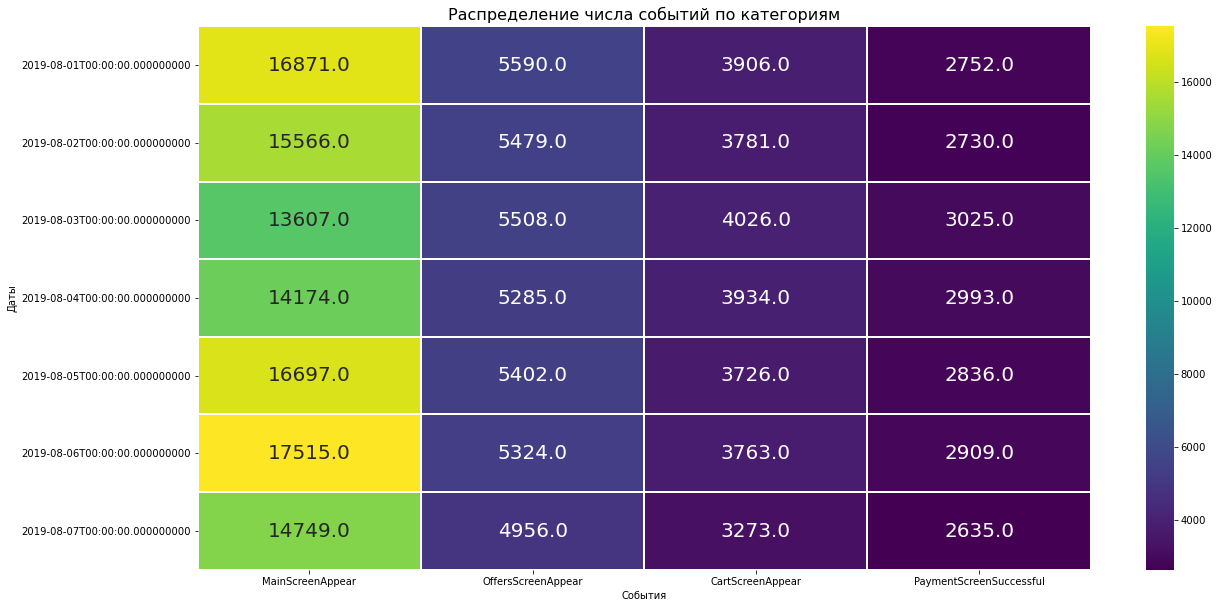

In [109]:
events_activity = logs.pivot_table(index='event_date',  columns='event_name', values='device_id_hash', aggfunc='count')
events_activity =events_activity[[ 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
plt.figure(figsize=(20, 10))
plt.title('Распределение числа событий по категориям', fontsize = 16)
sns.heatmap(events_activity, annot=True, fmt=".1f", linewidths=1, cmap = 'viridis', annot_kws={"size":20})
plt.xlabel('События')
plt.ylabel('Даты')
plt.show()

По частоте все события расположены по убыванию? что соответствует логичной последовательности:
- Main Screen Appear - посещение главной страницы    
- Offers Screen Appear - посещение страницы  с предложениями       
- Cart Screen Appear  - посещение корзины            
- Payment Screen Successful  - страница успешной оплаты  
- Tutorial  - руководство/инструкция 

Tutorial - посещается реже других. Это событие выбивается из общего ряда и может быть удалено из воронки.

##### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [110]:
#funnel =logs.pivot_table(index='event_name', values='device_id_hash', aggfunc=pd.Series.nunique).reset_index().sort_values(by='device_id_hash', ascending=False)
funnel =logs.pivot_table(index='event_name', values='device_id_hash', aggfunc=lambda x: x.nunique()).reset_index().sort_values(by='device_id_hash', ascending=False)
funnel.columns=['event_name', 'users']
funnel

,event_name,users
1,MainScreenAppear,7268
2,OffersScreenAppear,4442
0,CartScreenAppear,3584
3,PaymentScreenSuccessful,3391
4,Tutorial,808


In [111]:
logs['device_id_hash'].nunique() #количество уникальных пользователей 

7381

In [112]:
funnel['percentage']=funnel['users']/logs['device_id_hash'].nunique()
funnel['percentage']=funnel['percentage'].map('{:.1%}'.format)
funnel

,event_name,users,percentage
1,MainScreenAppear,7268,98.5%
2,OffersScreenAppear,4442,60.2%
0,CartScreenAppear,3584,48.6%
3,PaymentScreenSuccessful,3391,45.9%
4,Tutorial,808,10.9%


##### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События происходят в логичной последовательности. Из ряда выбивается Tutorial, которая, вероятно, не относится непосредственно к процессу покупки. Эту страницу посещают только в 10% случаев. Удалим её из воронки:

In [113]:
funnel = funnel.query('event_name != "Tutorial"')
funnel

,event_name,users,percentage
1,MainScreenAppear,7268,98.5%
2,OffersScreenAppear,4442,60.2%
0,CartScreenAppear,3584,48.6%
3,PaymentScreenSuccessful,3391,45.9%


In [114]:
fig = go.Figure(go.Funnel(y =  funnel['event_name'], x = funnel['users'], textinfo = "value+percent initial", marker = {"color": ["silver", "wheat", "lightsalmon", "red"]}))
fig.update_layout(title='Продуктовая воронка')  
fig.show()

##### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [115]:
funnel['every_next_step,%'] = (100-100*abs(funnel['users'].pct_change()).fillna(0)).round(1)
funnel

,event_name,users,percentage,"every_next_step,%"
1,MainScreenAppear,7268,98.5%,100.0
2,OffersScreenAppear,4442,60.2%,61.1
0,CartScreenAppear,3584,48.6%,80.7
3,PaymentScreenSuccessful,3391,45.9%,94.6


##### На каком шаге теряете больше всего пользователей?

Наибольшее количество потерянных пользователей наблюдается при переходе с главной страницы на страницу с предложениями: переход осуществили только 61,1% (39,9% потерянных переходов). Значительно меньше мы теряем при переходе со страницы предложений на страницу корзины - 19,3%(переходит 80,7%) и практически 94,6% (5,4% потерь) переходов оуществляется со страницы корзины на страницу успешной оплаты.

##### Какая доля пользователей доходит от первого события до оплаты?

До оплаты доходит 45,9% от общего числа пользователей.

# Вывод:
Посещение страницы Tutorial не имеет отношения к данной воронке, поэтому данные события были исключены из анализа. 
До оплаты доходит 45,9% от общего числа пользователей, воспользовавшихся приложением.
Наибольшее количество потерянных пользователей наблюдается при переходе с главной страницы на страницу с предложениями: переход осуществили только 61,1% (39,9% потерянных переходов). От посещения корзины к оплате переходит 94,6% пользователей

# Шаг 5. Изучение результатов  эксперимента <a name="5"></a>

##### задачи:
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

##### Сколько пользователей в каждой экспериментальной группе?

In [116]:
exp_users = logs.pivot_table(index='exp_id', values='device_id_hash', aggfunc=pd.Series.nunique).reset_index()
exp_users.columns=['exp_groups', 'users']
s=exp_users['users'][0]+exp_users['users'][1]
A1_A2 = pd.DataFrame({'exp_groups':'A1+A2', 'users':s}, index =[0])
exp_users = pd.concat([A1_A2, exp_users]).reset_index(drop = True)
exp_users

,exp_groups,users
0,A1+A2,4903
1,A1,2432
2,A2,2471
3,B,2478


##### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

##### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Количество пользователей в группах различается на 1,6%, что можно считать критерием успешного А/А теста.
Также на результаты не влияют аномалии и выбросы. 

In [117]:
#посмотрим, как распределены пользователи групп по событиям
exp_users_by_event = logs.query('event_name != "Tutorial"').pivot_table(index = 'event_name',columns='exp_id',  values='device_id_hash', aggfunc='nunique')
exp_users_by_event

exp_id,A1,A2,B
event_name,,,
CartScreenAppear,1215,1196,1173
MainScreenAppear,2399,2435,2434
OffersScreenAppear,1491,1478,1473
PaymentScreenSuccessful,1149,1116,1126


Самым популярным событием является MainScreenAppear - посещение главной страницы.

In [118]:
exp_users=exp_users.set_index(exp_users.columns[0])
exp_users #уникальное количество пользователей

,users
exp_groups,
A1+A2,4903
A1,2432
A2,2471
B,2478


In [119]:
#считаем долю пользователей по каждому событию по экспериментальным группам:
exp_event=exp_users_by_event.copy()

exp_event['A1+A2'] = exp_event['A1']+exp_event['A2']
exp_event['A1,%'] = exp_event['A1']/exp_users['users'][1]
exp_event['A2,%'] = exp_event['A2']/exp_users['users'][2]
exp_event['A1+A2,%'] = exp_event['A1+A2']/exp_users['users'][0]
exp_event['B,%'] = exp_event['B']/exp_users['users'][3]
exp_event

exp_id,A1,A2,B,A1+A2,"A1,%","A2,%","A1+A2,%","B,%"
event_name,,,,,,,,
CartScreenAppear,1215,1196,1173,2411,0.499589,0.484015,0.491740,0.473366
MainScreenAppear,2399,2435,2434,4834,0.986431,0.985431,0.985927,0.982244
OffersScreenAppear,1491,1478,1473,2969,0.613076,0.598138,0.605548,0.594431
PaymentScreenSuccessful,1149,1116,1126,2265,0.472451,0.451639,0.461962,0.454399


Считаем статистическую достоверность отличия между группами в разрезе событий. 
Сформулируем гипотезы:

- H0 - нулевая гипотеза: между  долями пользователей событий экспериментальных групп А1 и А2 **отсутствует разница** по статистическим критериям.
- H1 - альтернативная гипотеза :  долями пользователей событий   **различаются** по статистическим критериям.  

In [120]:
all_gr = logs.pivot_table(index='event_name', columns='exp_id',values='device_id_hash',aggfunc='nunique').sort_values('A1',ascending=False)
all_gr['A1+A2'] = all_gr['A1'] + all_gr['A2']
all_gr.drop(['Tutorial'], inplace=True)
all_gr

exp_id,A1,A2,B,A1+A2
event_name,,,,
MainScreenAppear,2399,2435,2434,4834
OffersScreenAppear,1491,1478,1473,2969
CartScreenAppear,1215,1196,1173,2411
PaymentScreenSuccessful,1149,1116,1126,2265


In [121]:
def z_test(exp1, exp2, event, alpha): 
    
    p1_event = all_gr.loc[event, exp1]
    p2_event = all_gr.loc[event, exp2] 
    p1_users = exp_users.loc[exp1, 'users'] 
    p2_users = exp_users.loc[exp2, 'users'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [122]:
for event in all_gr.index:
    z_test('A1', 'A2', event, 0.05)
    print()

Проверка для  A1 и A2, событие: MainScreenAppear, p-значение: 0.77
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: OffersScreenAppear, p-значение: 0.28
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: CartScreenAppear, p-значение: 0.28
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: PaymentScreenSuccessful, p-значение: 0.14
Не получилось отвергнуть нулевую гипотезу



In [123]:
for event in all_gr.index:
    z_test('A1', 'A2', event, 0.1)
    print()

Проверка для  A1 и A2, событие: MainScreenAppear, p-значение: 0.77
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: OffersScreenAppear, p-значение: 0.28
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: CartScreenAppear, p-значение: 0.28
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и A2, событие: PaymentScreenSuccessful, p-значение: 0.14
Не получилось отвергнуть нулевую гипотезу



Можно сказать, что разбиение на группы работает корректно.  При уровене значимости 5% и 10%  между долями пользователей  экспериментальных групп А1 и А2 отсутствует разница по статистическим критериям.

##### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Сформулируем гипотезы:

H0 - нулевая гипотеза: между долями пользователей событий экспериментальных групп А и В отсутствует разница по статистическим критериям.
H1 - альтернативная гипотеза : доли пользователей событий различаются по статистическим критериям.
Уровень значимости 5%

In [124]:
for event in all_gr.index:
    z_test('A1', 'B', event, 0.05)
    print()

Проверка для  A1 и B, событие: MainScreenAppear, p-значение: 0.24
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и B, событие: OffersScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и B, событие: CartScreenAppear, p-значение: 0.07
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и B, событие: PaymentScreenSuccessful, p-значение: 0.20
Не получилось отвергнуть нулевую гипотезу



In [125]:
for event in all_gr.index:
    z_test('A2', 'B', event, 0.05)
    print()

Проверка для  A2 и B, событие: MainScreenAppear, p-значение: 0.37
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: OffersScreenAppear, p-значение: 0.79
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: CartScreenAppear, p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.85
Не получилось отвергнуть нулевую гипотезу



In [126]:
for event in all_gr.index:
    z_test('A1+A2', 'B', event, 0.05)
    print()

Проверка для  A1+A2 и B, событие: MainScreenAppear, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: OffersScreenAppear, p-значение: 0.36
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: CartScreenAppear, p-значение: 0.14
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.54
Не получилось отвергнуть нулевую гипотезу



Также проведём расчёты с критическим уровнем статистической значимости равным 10% для А1/В, А2/В  и А1+А2/В групп:

In [127]:
for event in all_gr.index:
    z_test('A1', 'B', event, 0.1)
    print()

Проверка для  A1 и B, событие: MainScreenAppear, p-значение: 0.24
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и B, событие: OffersScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1 и B, событие: CartScreenAppear, p-значение: 0.07
Отвергаем нулевую гипотезу

Проверка для  A1 и B, событие: PaymentScreenSuccessful, p-значение: 0.20
Не получилось отвергнуть нулевую гипотезу



In [128]:
for event in all_gr.index:
    z_test('A2', 'B', event, 0.1)
    print()

Проверка для  A2 и B, событие: MainScreenAppear, p-значение: 0.37
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: OffersScreenAppear, p-значение: 0.79
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: CartScreenAppear, p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу

Проверка для  A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.85
Не получилось отвергнуть нулевую гипотезу



In [129]:
for event in all_gr.index:
    z_test('A1+A2', 'B', event, 0.1)
    print()

Проверка для  A1+A2 и B, событие: MainScreenAppear, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: OffersScreenAppear, p-значение: 0.36
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: CartScreenAppear, p-значение: 0.14
Не получилось отвергнуть нулевую гипотезу

Проверка для  A1+A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.54
Не получилось отвергнуть нулевую гипотезу



##### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

При проверке статистических гипотез был выбран  уровень значимости 5%. 
Всего было проведено 16 тестов в контрольных группах А1/А2, А1/В, А2/В и А1+А2/В.

Также использовался критический уровень статистической значимости равный 10%, где в одном из 16 тестов были обнаружены различия: проверка   A1 и B для события CartScreenAppear показала, что доли пользователей событий различаются по статистическим критериям (p-значение равное 7%). 

Вероятность не ошибиться ни разу за 16 тестов  равна:(1-альфа)^16.  При альфа=5% вероятность не ошибиться ни разу - 44%
Соответственно вероятность ошибиться  - 56%
При альфа=10% вероятность не ошибиться ни разу - 18,5%
Соответственно вероятность ошибиться  - 81,5%

С каждой новой проверкой гипотезы растёт вероятность ошибки первого рода (ложная тревога): если бы мы провели 8 тестов, то вероятность ошибиться снизилась до 34% для альфа=5% и до 57%  для альфа 10%.
**При большом количестве тестов лучше применять меньший уровень значимости: в данном случае 5%.**
Меньшие альфа-уровни дают бОльшую уверенность в том, что уже установленная альтернативная гипотеза значима, но при этом есть больший риск не отвергнуть ложную нулевую (или отвергнуть истинную альтернативную) гипотезу (ошибка второго рода, или ложноотрицательное решение). 

Таким образом, для уровня значимости 5% статистически значимых различий  не наблюдалось. 
Результат: Выборки не имеют статистически значимых различий для альфа =5%. Причиной этому может быть тот фактор, что посетителям сайта не важно, какой шрифт в приложении -  различия в контрольной и тестируемой группах отстутствуют. 

# Общие выводы:

После устранения выборосов данные представляли 193976 строк. В результате отброса старых данных были потеряны 49737 событий и 17 пользователей.
Всего в логе 5 уникальных событий:
- Main Screen Appear - посещение главной страницы    
- Offers Screen Appear - посещение страницы  с предложениями       
- Cart Screen Appear  - посещение корзины            
- Payment Screen Successful  - страница успешной оплаты  
- Tutorial  - руководство/инструкция 

Tutorial - событие, выбивающиеся из общего ряда, было удалено из анализа.

Количество уникальных пользователей в логе - 7381. На одного пользователя приходится 32 события. Для теста была выбрана только одна неделя (в логе дан период равный 14 дням).
Наибольшее количество потерянных пользователей наблюдается при переходе с главной страницы на страницу с предложениями: переход осуществили только 61,1% (39,9% потерянных переходов). Значительно меньше мы теряем при переходе со страницы предложений на страницу корзины - 19,3%(переходит 80,7%) и практически 94,6% (5,4% потерь) переходов оуществляется со страницы корзины на страницу успешной оплаты.
До оплаты доходит 45,9% от общего числа пользователей.

Выборки не имеют статистически значимых различий и  причиной этому может быть тот фактор, что посетителям сайта не важно, какой шрифт в приложении -  различия в контрольной и тестируемой группах отстутствуют. 

Анализ показал, что **изменения шрифта не требуется, и это новооведение не повлияет на итоговую конверсию.** 

#### [Вернуться к оглавлению](#шаг-0)